In [11]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home/gsatopo1/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator


from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/'

palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

### Survey parameters
We generate lightcones with the following parameters

|Redshifts|$\Omega$ (deg$^2$)|$\theta_{\rm FWHM}$ (arcmin)|R|
|---|---|---|---|
|2.5-3.5|400|2|700|

In [2]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    ang_lim=10*u.deg
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=1,
                      spectral_supersample=1,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      do_remove_mean=False,
                      Nmu=30,
                      kmax=2*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-ang_lim,RAObs_max=ang_lim, DECObs_min=-ang_lim,DECObs_max=ang_lim,
                    RA_min=-ang_lim,RA_max=ang_lim, DEC_min=-ang_lim,DEC_max=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.81568736,'beta':3.43531917,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=True))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

In [3]:
LC_CO=make_measurements(LC_params('CO'))

In [6]:
#LC_CO.update(angular_supersample=1, spectral_supersample=1, Tsys=0*u.K)
CO_map=np.asarray(LC_CO.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [78]:
np.save('../../map_noiseless_CO_T', CO_map)

In [8]:
LC_CII=make_measurements(LC_params('CII'))

In [9]:
#LC_CII.update(angular_supersample=1, spectral_supersample=1, Tsys=0*u.Jy/u.sr)
CII_map=np.asarray(LC_CII.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.21690681990786664
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.22609351109309683
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [79]:
np.save('../../map_noiseless_CII_I', CII_map)

In [10]:
LC_Lya=make_measurements(LC_params('Lyalpha'))

In [11]:
#LC_Lya.update(angular_supersample=1, spectral_supersample=1, Tsys=0*u.Jy/u.sr)
Lya_map=np.asarray(LC_Lya.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078652
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of Lyalpha line left out filtering = 0.22609306652174377
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [80]:
np.save('../../map_noiseless_Lya_I', Lya_map)

In [12]:
LC_HI=make_measurements(LC_params('HI'))

In [13]:
#LC_HI.update(angular_supersample=1, spectral_supersample=1, Tsys=0*u.K)
HI_map=np.asarray(LC_HI.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.22609324449220436
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [81]:
np.save('../../map_noiseless_HI_T', HI_map)

### Luminosity function

In [9]:
logMcat_CO, LCO=np.load('../../LM_CO.npy')

In [19]:
LC_CO.do_z_buffering

True

In [22]:
LC_CO.rside_obs_lim

array([4047.1229329, 4644.3564855])

In [34]:
#inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
#inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#cornerside = (LC_CO.raside_lim[1]**2+LC_CO.decside_lim[1]**2)**0.5
#ang = np.arctan(cornerside/LC_CO.rside_obs_lim[1])
#rbuffer = cornerside/np.sin(ang)
#zbuffer = LC_CO.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_CO.Mpch).value)
#nu_min = LC_CO.line_nu0['CO_J10']/(zbuffer+1)

#inds = (LC_CO.nuObs_line_halo['CO_J10'] >= nu_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky

#M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(u.Msun).value

#logMcat_CO=np.log10(M_in_survey)
#LCO = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(10.2, 14, 31)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO>=logM[i])&(logMcat_CO<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))     

meanLCO = np.asarray(meanLCO)

In [7]:
np.save('../../LM_CO', [logMcat_CO[LCO>0], LCO[LCO>0]])

In [35]:
#inds_RA = (LC_CII.halo_catalog['RA'] > LC_CII.RAObs_min.value)&(LC_CII.halo_catalog['RA'] < LC_CII.RAObs_max.value)
#inds_DEC = (LC_CII.halo_catalog['DEC'] > LC_CII.DECObs_min.value)&(LC_CII.halo_catalog['DEC'] < LC_CII.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#cornerside = (LC_CII.raside_lim[1]**2+LC_CII.decside_lim[1]**2)**0.5
#ang = np.arctan(cornerside/LC_CII.rside_obs_lim[1])
#rbuffer = cornerside/np.sin(ang)
#zbuffer = LC_CII.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_CII.Mpch).value)
#nu_min = LC_CII.line_nu0['CII']/(zbuffer+1)

#inds = (LC_CII.nuObs_line_halo['CII'] >= nu_min)&(LC_CII.nuObs_line_halo['CII'] <= LC_CII.nuObs_max)&inds_sky

#M_in_survey = LC_CII.halo_catalog['M_HALO'][inds]*LC_CII.Msunh.to(u.Msun).value

#logMcat_CII=np.log10(M_in_survey)
#LCII = LC_CII.halos_in_survey['CII']['Lhalo'].value
logM=np.linspace(10.2, 14, 31)

meanLCII=[]
for i in range(len(logM)-1):
    inds = (logMcat_CII>=logM[i])&(logMcat_CII<logM[i+1])&(LCII>0)
    Lbin = LCII[inds]
    meanLCII.append(np.mean(Lbin))     

meanLCII = np.asarray(meanLCII)

In [16]:
np.save('../../LM_CII', [logMcat_CII[LCII>0], LCII[LCII>0]])

In [36]:
#inds_RA = (LC_Lya.halo_catalog['RA'] > LC_Lya.RAObs_min.value)&(LC_Lya.halo_catalog['RA'] < LC_Lya.RAObs_max.value)
#inds_DEC = (LC_Lya.halo_catalog['DEC'] > LC_Lya.DECObs_min.value)&(LC_Lya.halo_catalog['DEC'] < LC_Lya.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#cornerside = (LC_Lya.raside_lim[1]**2+LC_Lya.decside_lim[1]**2)**0.5
#ang = np.arctan(cornerside/LC_Lya.rside_obs_lim[1])
#rbuffer = cornerside/np.sin(ang)
#zbuffer = LC_Lya.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_Lya.Mpch).value)
#nu_min = LC_Lya.line_nu0['Lyalpha']/(zbuffer+1)

#inds = (LC_Lya.nuObs_line_halo['Lyalpha'] >= nu_min)&(LC_Lya.nuObs_line_halo['Lyalpha'] <= LC_Lya.nuObs_max)&inds_sky

#M_in_survey = LC_Lya.halo_catalog['M_HALO'][inds]*LC_Lya.Msunh.to(u.Msun).value

#logMcat_Lya=np.log10(M_in_survey)
#LLya = LC_Lya.halos_in_survey['Lyalpha']['Lhalo'].value
logM=np.linspace(10.2, 14, 31)

meanLLya=[]
for i in range(len(logM)-1):
    inds = (logMcat_Lya>=logM[i])&(logMcat_Lya<logM[i+1])&(LLya>0)
    Lbin = LLya[inds]
    meanLLya.append(np.mean(Lbin))     

meanLLya = np.asarray(meanLLya)

In [23]:
np.save('../../LM_Lya', [logMcat_Lya[LLya>0], LLya[LLya>0]])

In [37]:
#inds_RA = (LC_HI.halo_catalog['RA'] > LC_HI.RAObs_min.value)&(LC_HI.halo_catalog['RA'] < LC_HI.RAObs_max.value)
#inds_DEC = (LC_HI.halo_catalog['DEC'] > LC_HI.DECObs_min.value)&(LC_HI.halo_catalog['DEC'] < LC_HI.DECObs_max.value)
#inds_sky = inds_RA&inds_DEC

#cornerside = (LC_HI.raside_lim[1]**2+LC_HI.decside_lim[1]**2)**0.5
#ang = np.arctan(cornerside/LC_HI.rside_obs_lim[1])
#rbuffer = cornerside/np.sin(ang)
#zbuffer = LC_HI.cosmo.redshift_at_comoving_radial_distance((rbuffer*LC_HI.Mpch).value)
#nu_min = LC_HI.line_nu0['HI']/(zbuffer+1)

#inds = (LC_HI.nuObs_line_halo['HI'] >= nu_min)&(LC_HI.nuObs_line_halo['HI'] <= LC_HI.nuObs_max)&inds_sky

#M_in_survey = LC_HI.halo_catalog['M_HALO'][inds]*LC_HI.Msunh.to(u.Msun).value

#logMcat_HI=np.log10(M_in_survey)
#LHI = LC_HI.halos_in_survey['HI']['Lhalo'].value
logM=np.linspace(10.2, 14, 31)

meanLHI=[]
for i in range(len(logM)-1):
    inds = (logMcat_HI>=logM[i])&(logMcat_HI<logM[i+1])&(LHI>0)
    Lbin = LHI[inds]
    meanLHI.append(np.mean(Lbin))     

meanLHI = np.asarray(meanLHI)

In [8]:
np.save('../../LM_HI', [logMcat_HI[LHI>0], LHI[LHI>0]])

In [29]:
dark_blue='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [dark_blue,turquoise,yellow,yellow_orange,orange])

/home/gsatopo1/library/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


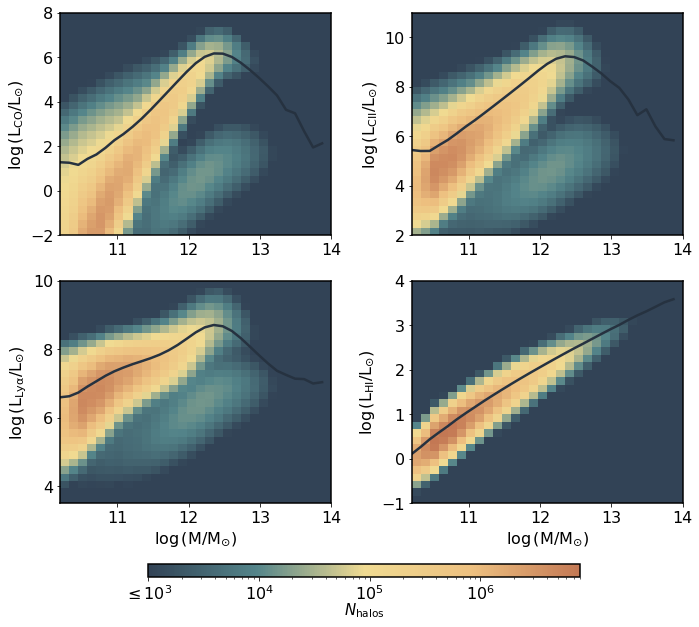

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

ax[0,0].hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[np.linspace(10.2, 14, 31), np.linspace(-2, 8, 31)], 
               norm=matplotlib.colors.LogNorm(vmin=1e3, vmax=8e6), cmap=cmap)
ax[0,0].plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax[0,0].set_facecolor(dark_blue)
ax[0,0].set_ylim(-2, 8)
ax[0,0].set_xlim(10.2, 14)
#ax[0,0].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[0,0].set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')
#ax0 = ax[0].twinx()
#ax0.plot(logM[:-1], meanLCO*(u.Lsun.to(u.erg/u.s)), alpha=0)

ax[0,1].hist2d(logMcat_CII[LCII>0], np.log10(LCII[LCII>0]), bins=[np.linspace(10.2, 14, 31), np.linspace(2, 11, 31)],
               norm=matplotlib.colors.LogNorm(vmin=1e3, vmax=8e6), cmap=cmap)
ax[0,1].plot(logM[:-1], np.log10(meanLCII), color='#263240')
ax[0,1].set_facecolor(dark_blue)
ax[0,1].set_ylim(2, 11)
ax[0,1].set_xlim(10.2, 14)
#ax[0,1].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[0,1].set_ylabel(r'$\log$(L$_{\rm CII}$/L$_{\odot}$)')


ax[1,0].hist2d(logMcat_Lya[LLya>0], np.log10(LLya[LLya>0]), bins=[np.linspace(10.2, 14, 31), np.linspace(3.5, 10, 31)], 
               norm=matplotlib.colors.LogNorm(vmin=1e3, vmax=8e6), cmap=cmap)
ax[1,0].plot(logM[:-1], np.log10(meanLLya), color='#263240')
ax[1,0].set_facecolor(dark_blue)
ax[1,0].set_ylim(3.5, 10)
ax[1,0].set_xlim(10.2, 14)
ax[1,0].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[1,0].set_ylabel(r'$\log$(L$_{\rm Ly\alpha}$/L$_{\odot}$)')

im=ax[1,1].hist2d(logMcat_HI[LHI>0], np.log10(LHI[LHI>0]), bins=[np.linspace(10.2, 14, 31), np.linspace(-1, 4, 31)], 
                  norm=matplotlib.colors.LogNorm(vmin=1e3, vmax=8e6), cmap=cmap)
ax[1,1].plot(logM[:-1], np.log10(meanLHI), color='#263240')
ax[1,1].set_facecolor(dark_blue)
#ax[2].set_ylim(2.5, 10.5)
#ax[2].set_xlim(10, 14)

cbar_ax = fig.add_axes([0.22, -0.02, 0.6, 0.022])
cbar_ax.set_title(r'$N_{\rm halos}$', fontsize=15, x=0.5, y=-3.5)
cbar=fig.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
cbar.set_ticks([1e3, 1e4, 1e5, 1e6])
cbar.set_ticklabels([r'$\leq 10^3$','$10^4$','$10^5$','$10^6$'])


ax[1,1].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[1,1].set_ylabel(r'$\log$(L$_{\rm HI}$/L$_{\odot}$)')

plt.tight_layout()
plt.savefig('../../LM_2dhist.png', bbox_inches='tight', dpi=300)
plt.savefig('../../LM_2dhist.pdf', bbox_inches='tight', dpi=300)

### Studying the HI scatter

In [9]:
inds_RA = (LC_HI.halo_catalog['RA'] > LC_HI.RAObs_min.value)&(LC_HI.halo_catalog['RA'] < LC_HI.RAObs_max.value)
inds_DEC = (LC_HI.halo_catalog['DEC'] > LC_HI.DECObs_min.value)&(LC_HI.halo_catalog['DEC'] < LC_HI.DECObs_max.value)
inds_sky = inds_RA&inds_DEC
inds_redshift=(LC_HI.nuObs_line_halo['HI'] >= LC_HI.nuObs_min)&(LC_HI.nuObs_line_halo['HI'] <= LC_HI.nuObs_max)
inds_SFR=(LC_HI.halo_catalog['SFR_HALO']>0)

inds = inds_SFR&inds_redshift&inds_sky
Mhalo_Msun = (LC_HI.halo_catalog['M_HALO'][inds]*LC_HI.Msunh).to(u.Msun)

In [25]:
h=0.678
M0=2.9e9*u.Msun/h
Mmin=6.7e10*u.Msun/h
alpha=0.76
MHI=M0*np.exp(-(Mmin/Mhalo_Msun)**0.35)*(Mhalo_Msun/Mmin)**alpha

sigma_MHI=0.2
rng=np.random.default_rng(0)
sigma_base_e = sigma_MHI*2.302585
MHI_samples = MHI*rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, MHI.shape)

In [28]:
def MHI_VN(M, a, M0, Mmin):
    return M0*np.exp(-(Mmin/M)**0.35)*(M/Mmin)**a

logM=np.linspace(7, 15, 50)
params=[[0.76-0.05,2.9e9-2e9,6.7e10-4e10],[0.76,2.9e9,6.7e10], [0.76+0.05,2.9e9+2e9,6.7e10+4e10]]
h=0.678
M_VN=[]
for i in range(len(params)):
    a,M0,Mmin=params[i]
    M_VN.append(MHI_VN((10**logM)*u.Msun, a, M0*u.Msun/h, Mmin*u.Msun/h))

/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home-net/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


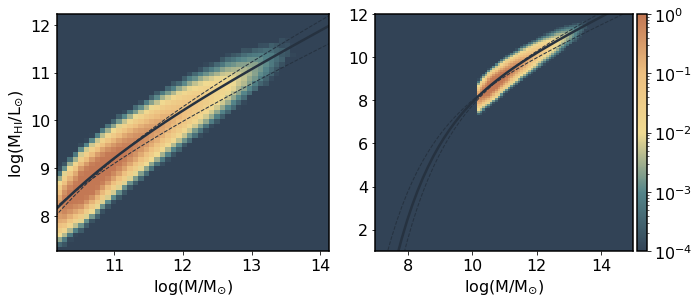

In [32]:
drinkslogM=np.linspace(7, 15, 50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5))

ax[0].hist2d(np.log10(Mhalo_Msun.value), np.log10(MHI_samples.value), bins=[50, 50], norm=mpl.colors.LogNorm(), 
             cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax[0].plot(logM, np.log10(M_VN[0].value), '--',lw=1, color='#263240')
ax[0].plot(logM, np.log10(M_VN[1].value), color='#263240')
ax[0].plot(logM, np.log10(M_VN[2].value), '--',lw=1, color='#263240')
ax[0].set_facecolor(grey)
ax[0].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[0].set_ylabel(r'$\log$(M$_{\rm HI}$/L$_{\odot}$)')

im=ax[1].hist2d(np.log10(Mhalo_Msun.value), np.log10(MHI_samples.value), bins=[50, 50], norm=mpl.colors.LogNorm(), 
             cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax[1].plot(logM, np.log10(M_VN[0].value), '--',lw=1, color='#263240')
ax[1].plot(logM, np.log10(M_VN[1].value), color='#263240')
ax[1].plot(logM, np.log10(M_VN[2].value), '--',lw=1, color='#263240')
ax[1].set_facecolor(grey)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='4%', pad=0.05)
fig.colorbar(im[3], cax=cax, orientation='vertical')
ax[1].set_xlabel(r'$\log$(M/M$_{\odot}$)')
ax[1].set_ylim(1, 12)
ax[1].set_xlim(7, 15)

plt.tight_layout()

# Noiseless results

## VID

In [82]:
#CO_map=np.load('../../map_noiseless_CO.npy')
TiCO_edge=np.logspace(-1, np.log10(np.max(CO_map)), 50+1)

#TiCO_pos=np.logspace(0, np.log10(np.max(CO_map)), 50+1)
#TiCO_neg=-np.logspace(np.log10(np.max(CO_map)), 0, 50+1)
#TiCO_edge=np.concatenate((TiCO_neg[TiCO_neg>=np.min(CO_map)],TiCO_pos))
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO_LC=np.histogram(CO_map.flatten(), bins=TiCO_edge)[0]

In [83]:
#CII_map=np.load('../../map_noiseless_CII.npy')
TiCII_edge=np.logspace(-1, np.log10(np.max(CII_map)), 50+1)

#TiCII_pos=np.logspace(0, np.log10(np.max(CII_map)), 50+1)
#TiCII_neg=-np.logspace(np.log10(np.max(CII_map)), 0, 50+1)
#TiCII_edge=np.concatenate((TiCII_neg[TiCII_neg>=np.min(CII_map)],TiCII_pos))
TiCII=(TiCII_edge[:-1]+TiCII_edge[1:])/2.

BiCII_LC=np.histogram(CII_map.flatten(), bins=TiCII_edge)[0]

In [84]:
#Lya_map=np.load('../../map_noiseless_Lya.npy')
TiLya_edge=np.logspace(-1, np.log10(np.max(Lya_map)), 50+1)
#TiLya_edge=np.linspace(-10, 100, 50+1)

#TiLya_pos=np.logspace(0, np.log10(np.max(Lya_map)), 50+1)
#TiLya_neg=-np.logspace(np.log10(np.max(Lya_map)), 0, 50+1)
#TiLya_edge=np.concatenate((TiLya_neg[TiLya_neg>=np.min(Lya_map)],TiLya_pos))
TiLya=(TiLya_edge[:-1]+TiLya_edge[1:])/2.

BiLya_LC=np.histogram(Lya_map.flatten(), bins=TiLya_edge)[0]

In [85]:
#HI_map=np.load('../../map_noiseless_HI.npy')
TiHI_edge=np.logspace(-1, np.log10(np.max(HI_map)), 50+1)
#TiHI_edge=np.linspace(-10, 100, 50+1)

TiHI=(TiHI_edge[:-1]+TiHI_edge[1:])/2.
BiHI_LC=np.histogram(HI_map.flatten(), bins=TiHI_edge)[0]

Text(0.5, 0, '$I$ (Jy sr$^{-1}$)')

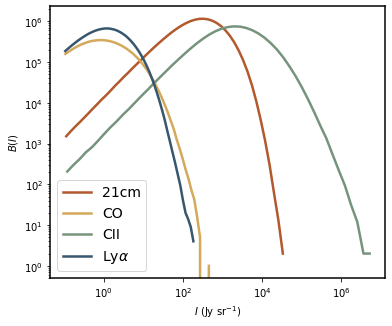

In [26]:
blue='#38576e'
yellow='#d4a95b'
orange='#b3592e'
green='#76947d'

plt.figure(figsize=(6,5))
plt.loglog(TiHI, BiHI_LC, color=orange, label=r'21cm')
plt.loglog(TiCO, BiCO_LC, color=yellow, label='CO')
plt.loglog(TiCII, BiCII_LC, color=green, label='CII')
plt.loglog(TiLya, BiLya_LC, color=blue, label=r'Ly$\alpha$')
#plt.xlim(0.1, 1.3e5)
#plt.ylim(1e3, 1e7)
plt.legend( fontsize=14)
plt.ylabel(r'$B(I)$')
plt.xlabel('$I$ (Jy sr$^{-1}$)')
#plt.savefig('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/VID_noiseless.pdf', dpi=300)

### Power spectrum

In [9]:
kCO_nonoise=LC_CO.k_Pk_poles
PkCO_0_nonoise=LC_CO.Pk_0
PkCO_2_nonoise=LC_CO.Pk_2

In [6]:
#save files with h-ful units
np.save('../../PkCO_noiseless_T', [LC_CO.k_Pk_poles, LC_CO.Pk_0, LC_CO.Pk_2])

In [ ]:
PkCII_0=LC_CII.Pk_0
PkCII_2=LC_CII.Pk_2

In [12]:
np.save('../../PkCII_noiseless_I', [LC_CII.k_Pk_poles, LC_CII.Pk_0, LC_CII.Pk_2])

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.21690681990786664
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.22609351109309683
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [ ]:
PkLya_0=LC_Lya.Pk_0
PkLya_2=LC_Lya.Pk_2

In [13]:
np.save('../../PkLya_noiseless_I', [LC_Lya.k_Pk_poles, LC_Lya.Pk_0, LC_Lya.Pk_2])

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078652
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of Lyalpha line left out filtering = 0.22609306652174377
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [ ]:
PkHI_0=LC_HI.Pk_0
PkHI_2=LC_HI.Pk_2

In [14]:
np.save('../../PkHI_noiseless_T', [LC_HI.k_Pk_poles, LC_HI.Pk_0, LC_HI.Pk_2])

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.22609324449220436
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [74]:
kCO_nonoise, PkCO_0_nonoise, PkCO_2_nonoise = np.load('../../PkCO_noiseless_T.npy')
#kCII_nonoise, PkCII_0_nonoise, PkCII_2_nonoise = np.load('../../PkCII_noiseless.npy')
#kLya, PkLya_0, PkLya_2 = np.load('../../PkLya_noiseless.npy')
#kHI, PkHI_0, PkHI_2 = np.load('../../PkHI_noiseless.npy')

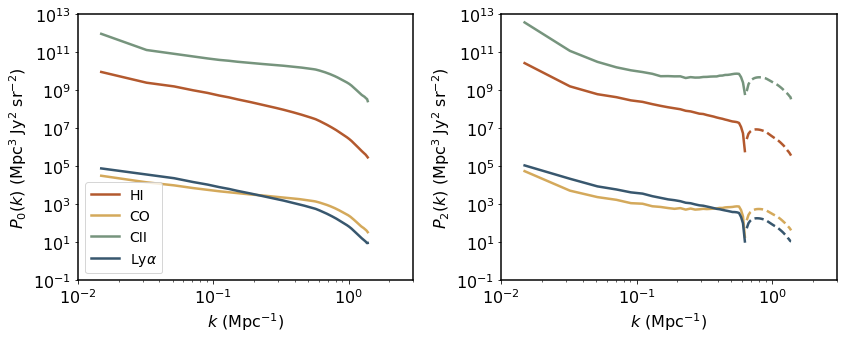

In [88]:
blue='#38576e'
yellow='#d4a95b'
orange='#b3592e'
green='#76947d'

hubble=0.678

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(LC_HI.k_Pk_poles*hubble, LC_HI.Pk_0/(hubble**3), color=orange, label=r'HI')
plt.loglog(LC_CO.k_Pk_poles*hubble, LC_CO.Pk_0/(hubble**3), color=yellow, label='CO')
plt.loglog(LC_CII.k_Pk_poles*hubble, LC_CII.Pk_0/(hubble**3), color=green, label="CII")
plt.loglog(LC_Lya.k_Pk_poles*hubble, LC_Lya.Pk_0/(hubble**3), color=blue, label=r'Ly$\alpha$')

plt.ylim(1e-1,1e13)
plt.xlim(1e-2, 3)
plt.xlabel('$k$ (Mpc$^{-1})$')
plt.ylabel('$P_0 (k)$ (Mpc$^3$ Jy$^2$ sr$^{-2}$)')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(LC_HI.k_Pk_poles[LC_HI.Pk_2>=0]*hubble, LC_HI.Pk_2[LC_HI.Pk_2>=0]/(hubble**3), color=orange)
plt.loglog(LC_HI.k_Pk_poles[LC_HI.Pk_2<0]*hubble, abs(LC_HI.Pk_2[LC_HI.Pk_2<0])/(hubble**3), '--', color=orange)

plt.loglog(LC_CO.k_Pk_poles[LC_CO.Pk_2>=0]*hubble, LC_CO.Pk_2[LC_CO.Pk_2>=0]/(hubble**3), color=yellow)
plt.loglog(LC_CO.k_Pk_poles[LC_CO.Pk_2<0]*hubble, abs(LC_CO.Pk_2[LC_CO.Pk_2<0])/(hubble**3), '--', color=yellow)

plt.loglog(LC_CII.k_Pk_poles[LC_CII.Pk_2>=0]*hubble, LC_CII.Pk_2[LC_CII.Pk_2>=0]/(hubble**3), color=green)
plt.loglog(LC_CII.k_Pk_poles[LC_CII.Pk_2<0]*hubble, abs(LC_CII.Pk_2[LC_CII.Pk_2<0])/(hubble**3), '--', color=green)

plt.loglog(LC_Lya.k_Pk_poles[LC_Lya.Pk_2>=0]*hubble, LC_Lya.Pk_2[LC_Lya.Pk_2>=0]/(hubble**3), color=blue)
plt.loglog(LC_Lya.k_Pk_poles[LC_Lya.Pk_2<0]*hubble, abs(LC_Lya.Pk_2[LC_Lya.Pk_2<0])/(hubble**3), '--', color=blue)

plt.ylim(1e-1,1e13)
plt.xlim(1e-2, 3)
plt.xlabel('$k$ (Mpc$^{-1})$')
plt.ylabel('$P_2 (k)$ (Mpc$^3$ Jy$^2$ sr$^{-2}$)')

plt.tight_layout()
#plt.savefig('/home-2/gsatopo1@jhu.edu/code/LIM Lightcones/Pk_noiseless.pdf', dpi=300, bbox_inches='tight')

### Compute system temperature for results with noise

We fix the same instrumental parameters for all experiments, with $N_{\rm feeds} = 1000$, $t_{\rm obs} = 10000$ h, and $\theta_{\rm beam} = 2$ arcmin, and find the value of $T_{\rm sys}$ that leads to a signal-to-noise ratio of 5 at $k=0.1$ Mpc$^{-1}$.

In [89]:
kCO, PkCO_0, PkCO_2 = np.load('../../PkCO_noiseless_T.npy')

In [90]:
Nmesh = np.array([LC_CO.Nchan,LC_CO.Npixside[0], LC_CO.Npixside[1]], dtype=int)
Vvox= (LC_CO.Lbox.value/Nmesh).prod()*(LC_CO.Lbox.unit**3)

PkCO_interp=interp1d(kCO*hubble, PkCO_0/(hubble**3))
sigma_N=np.sqrt(PkCO_interp(0.1)*(u.uK**2)*u.Mpc**3/(5*Vvox.to(u.Mpc**3)))
Tsys_CO=(sigma_N*np.sqrt(LC_CO.Nfeeds*LC_CO.dnu*LC_CO.tobs/LC_CO.Npix)).to(u.K)
print(sigma_N, Tsys_CO)

4.1912230710121365 uK 6.587147919523295 K


In [91]:
kCII, PkCII_0, PkCII_2 = np.load('../../PkCII_noiseless_I.npy')

In [99]:
LC_CII.beam_width

<Quantity 0.8494 arcmin>

In [108]:
PkCII_interp=interp1d(kCII*hubble, PkCII_0/(hubble**3))
sigma_N=np.sqrt(PkCII_interp(0.1)*(u.Jy**2/u.sr**2)*u.Mpc**3/(5*Vvox.to(u.Mpc**3)))
Tsys_CII=(sigma_N*np.sqrt(LC_CII.Nfeeds*LC_CII.tobs/LC_CII.Npix)).to(u.Jy*u.s**0.5/u.sr)
print(sigma_N, Tsys_CII)

11965.264698559044 Jy / sr 2930879.3148806035 Jy s(1/2) / sr


In [93]:
kLya, PkLya_0, PkLya_2 = np.load('../../PkLya_noiseless_I.npy')

In [110]:
PkLya_interp=interp1d(kLya*hubble, PkLya_0/(hubble**3))
sigma_N=np.sqrt(PkLya_interp(0.1)*(u.Jy**2/u.sr**2)*u.Mpc**3/(5*Vvox.to(u.Mpc**3)))
Tsys_Lya=(sigma_N*np.sqrt(LC_Lya.Nfeeds*LC_Lya.tobs/LC_Lya.Npix)).to(u.Jy*u.s**0.5/u.sr)
print(sigma_N, Tsys_Lya)

5.612509716916378 Jy / sr 1374.7784982857586 Jy s(1/2) / sr


In [95]:
kHI, PkHI_0, PkHI_2 = np.load('../../PkHI_noiseless_T.npy')

In [96]:
PkHI_interp=interp1d(kHI*hubble, PkHI_0/(hubble**3))
sigma_N=np.sqrt(PkHI_interp(0.1)*(u.uK**2)*u.Mpc**3/(5*Vvox.to(u.Mpc**3)))
Tsys_HI=(sigma_N*np.sqrt(LC_HI.Nfeeds*LC_HI.dnu*LC_HI.tobs/LC_HI.Npix)).to(u.K)
print(sigma_N, Tsys_HI)

1441.7410185695212 uK 251.53084193613057 K


# Results with noise

In [3]:
def LC_params(line):
    h=0.678
    zmin = 2.5;zmax = 3.5
    zmid=(zmax+zmin)/2
    R=700
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='nearest',
                      angular_supersample=1,
                      spectral_supersample=1,
                      cube_mode='inner_cube',
                      do_remove_mean=True,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      kmax=3*u.Mpc**-1,
                      seed=0)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.03, 
                    RAObs_min=-10*u.deg,RAObs_max=10*u.deg, DECObs_min=-10*u.deg,DECObs_max=10*u.deg,
                    RA_min=-10*u.deg,RA_max=10*u.deg, DEC_min=-10*u.deg,DEC_max=10*u.deg,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin,tobs=10000*u.hr,do_angular_smooth=True,do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zmin), nuObs_min=nu_CO/(1+zmax),
                           dnu=dnu, 
                           Tsys=6.59*u.K))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zmin), nuObs_min=nu_CII/(1+zmax),
                               dnu=dnu,
                               Tsys=2.93e6*u.Jy*u.s**0.5/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zmin), nuObs_min=nu_Lya/(1+zmax),
                               dnu=dnu,
                               Tsys=1.37e3*u.Jy*u.s**0.5/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zmin), nuObs_min=nu_HI/(1+zmax),
                        dnu=dnu,
                        Tsys=251.5*u.K))
        obs_params.update(model_params)
    return obs_params

In [4]:
LC_CO=make_measurements(LC_params('CO'))
CO_map=np.asarray(LC_CO.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [7]:
kCO_noise=LC_CO.k_Pk_poles
PkCO_0_noise=LC_CO.Pk_0
PkCO_2_noise=LC_CO.Pk_2

In [5]:
LC_CII=make_measurements(LC_params('CII'))
CII_map=np.asarray(LC_CII.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.21690681990786664
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.22609351109309683
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [6]:
LC_Lya=make_measurements(LC_params('Lyalpha'))
Lya_map=np.asarray(LC_Lya.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078652
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of Lyalpha line left out filtering = 0.22609306652174377
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [7]:
LC_HI=make_measurements(LC_params('HI'))
HI_map=np.asarray(LC_HI.obs_3d_map)

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-squareLC/lightcone_MDPL2UM_173.fits
/home/gsatopo1/data-mkamion1/MDPL2-UM-

../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.22609324449220436
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [87]:
LC_CO.update(Tsys=6.59*u.K)
LC_CII.update(Tsys=2.93e6*u.Jy*u.s**0.5/u.sr)
LC_Lya.update(Tsys=1.37e3*u.Jy*u.s**0.5/u.sr)
LC_HI.update(Tsys=251.5*u.K)

In [8]:
COmap_noise=np.asarray(LC_CO.obs_3d_map+LC_CO.noise_3d_map)
CIImap_noise=np.asarray(LC_CII.obs_3d_map+LC_CII.noise_3d_map)
Lyamap_noise=np.asarray(LC_Lya.obs_3d_map+LC_Lya.noise_3d_map)
HImap_noise=np.asarray(LC_HI.obs_3d_map+LC_HI.noise_3d_map)

In [9]:
COmap_nonoise=np.asarray(LC_CO.obs_3d_map)
CIImap_nonoise=np.asarray(LC_CII.obs_3d_map)
Lyamap_nonoise=np.asarray(LC_Lya.obs_3d_map)
HImap_nonoise=np.asarray(LC_HI.obs_3d_map)

In [89]:
np.save('../../map_noise_CO_T', COmap_noise)
np.save('../../map_noise_CII_I', CIImap_noise)
np.save('../../map_noise_Lya_I', Lyamap_noise)
np.save('../../map_noise_HI_T', HImap_noise)

In [4]:
COmap_nonoise=np.load('../../map_noiseless_CO_T.npy')
COmap_noise=np.load('../../map_noise_CO_T.npy')

TiCO_edge=np.logspace(-1, np.log10(np.max(COmap_nonoise)), 50+1)
#TiCO_edge=np.linspace(-2*np.std(COmap_nonoise), 20*np.std(COmap_nonoise), 50+1)
TiCO=(TiCO_edge[:-1]+TiCO_edge[1:])/2.

BiCO_nonoise=np.histogram(COmap_nonoise.flatten(), bins=TiCO_edge)[0]
BiCO_noise=np.histogram(COmap_noise.flatten(), bins=TiCO_edge)[0]

In [19]:
print(np.sum(BiCO_nonoise)/len(COmap_nonoise.flatten()))
print(np.sum(BiCO_noise)/len(COmap_noise.flatten()))

0.14460560763888888
0.39957


In [5]:
CIImap_nonoise=np.load('../../map_noiseless_CII_I.npy')
CIImap_noise=np.load('../../map_noise_CII_I.npy')

TiCII_edge=np.logspace(2.8, np.log10(np.max(CIImap_nonoise)), 50+1)
#TiCII_edge=np.linspace(-2*np.std(CIImap_nonoise), 20*np.std(CIImap_nonoise), 50+1)
TiCII=(TiCII_edge[:-1]+TiCII_edge[1:])/2.

BiCII_nonoise=np.histogram(CIImap_nonoise.flatten(), bins=TiCII_edge)[0]
BiCII_noise=np.histogram(CIImap_noise.flatten(), bins=TiCII_edge)[0]

In [20]:
print(np.sum(BiCII_nonoise)/len(CIImap_nonoise.flatten()))
print(np.sum(BiCII_noise)/len(CIImap_noise.flatten()))

0.15501588541666667
0.3966355902777778


In [6]:
Lyamap_nonoise=np.load('../../map_noiseless_Lya_I.npy')
Lyamap_noise=np.load('../../map_noise_Lya_I.npy')

TiLya_edge=np.logspace(0.1, np.log10(np.max(Lyamap_nonoise)), 50+1)
#TiLya_edge=np.linspace(-2*np.std(Lyamap_nonoise), 20*np.std(Lyamap_nonoise), 50+1)
TiLya=(TiLya_edge[:-1]+TiLya_edge[1:])/2.

BiLya_nonoise=np.histogram(Lyamap_nonoise.flatten(), bins=TiLya_edge)[0]
BiLya_noise=np.histogram(Lyamap_noise.flatten(), bins=TiLya_edge)[0]

In [21]:
print(np.sum(BiLya_nonoise)/len(Lyamap_nonoise.flatten()))
print(np.sum(BiLya_noise)/len(Lyamap_noise.flatten()))

0.20971869791666667
0.3492603993055556


In [7]:
HImap_nonoise=np.load('../../map_noiseless_HI_T.npy')
HImap_noise=np.load('../../map_noise_HI_T.npy')

TiHI_edge=np.logspace(2.5, np.log10(np.max(HImap_nonoise)), 50+1)
#TiHI_edge=np.linspace(-2*np.std(HImap_nonoise), 20*np.std(HImap_nonoise), 50+1)
TiHI=(TiHI_edge[:-1]+TiHI_edge[1:])/2.

BiHI_nonoise=np.histogram(HImap_nonoise.flatten(), bins=TiHI_edge)[0]
BiHI_noise=np.histogram(HImap_noise.flatten(), bins=TiHI_edge)[0]

In [32]:
print(np.sum(BiHI_nonoise)/len(HImap_nonoise.flatten()))
print(np.sum(BiHI_noise)/len(HImap_noise.flatten()))

0.21933559027777777
0.39278088541666667


In [111]:
Ti_edge=np.linspace(-1.5, 2.5, 50+1)
Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

COmap_noise_studentized=(COmap_noise-np.mean(COmap_noise))/np.std(COmap_noise)
CIImap_noise_studentized=(CIImap_noise-np.mean(CIImap_noise))/np.std(CIImap_noise)
Lyamap_noise_studentized=(Lyamap_noise-np.mean(Lyamap_noise))/np.std(Lyamap_noise)
HImap_noise_studentized=(HImap_noise-np.mean(HImap_noise))/np.std(HImap_noise)

StdizedCO_noise=np.histogram(COmap_noise_studentized.flatten(), bins=Ti_edge)[0]
StdizedCII_noise=np.histogram(CIImap_noise_studentized.flatten(), bins=Ti_edge)[0]
StdizedLya_noise=np.histogram(Lyamap_noise_studentized.flatten(), bins=Ti_edge)[0]
StdizedHI_noise=np.histogram(HImap_noise_studentized.flatten(), bins=Ti_edge)[0]

In [112]:
#Ti_edge=np.linspace(-0.75, 2, 50+1)
#Ti=(Ti_edge[:-1]+Ti_edge[1:])/2.

COmap_nonoise_studentized=(COmap_nonoise-np.mean(COmap_nonoise))/np.std(COmap_nonoise)
CIImap_nonoise_studentized=(CIImap_nonoise-np.mean(CIImap_nonoise))/np.std(CIImap_nonoise)
Lyamap_nonoise_studentized=(Lyamap_nonoise-np.mean(Lyamap_nonoise))/np.std(Lyamap_nonoise)
HImap_nonoise_studentized=(HImap_nonoise-np.mean(HImap_nonoise))/np.std(HImap_nonoise)

StdizedCO_nonoise=np.histogram(COmap_nonoise_studentized.flatten(), bins=Ti_edge)[0]
StdizedCII_nonoise=np.histogram(CIImap_nonoise_studentized.flatten(), bins=Ti_edge)[0]
StdizedLya_nonoise=np.histogram(Lyamap_nonoise_studentized.flatten(), bins=Ti_edge)[0]
StdizedHI_nonoise=np.histogram(HImap_nonoise_studentized.flatten(), bins=Ti_edge)[0]

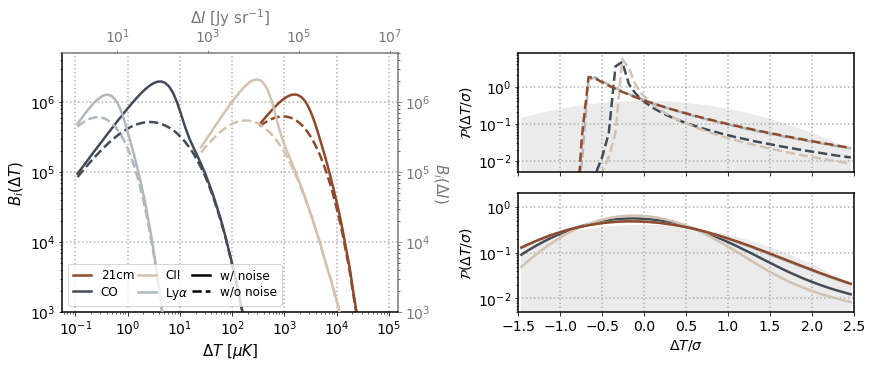

In [119]:
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

def gauss_norm(x):
    return np.exp(-x**2/2)/(np.sqrt(2*np.pi))

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(12,5),constrained_layout=True)
gs = GridSpec(2, 2, figure=fig)

ax00=fig.add_subplot(gs[:, 0])
ax01=fig.add_subplot(gs[:, 0], frame_on=False)

ax00.loglog(TiCO, BiCO_noise, color=dark_blue)
ax00.loglog(TiCO, BiCO_nonoise, '--', color=dark_blue)
ax00.loglog(TiHI, BiHI_noise, color=dark_red)
ax00.loglog(TiHI, BiHI_nonoise, '--', color=dark_red)
ax00.set_xlabel(r"$\Delta T$ [$\mu K$]", fontsize = 15)
ax00.set_ylabel("$B_{i}(\Delta T)$", fontsize=15)
ax00.set_ylim(1e3,5e6)

ax01.xaxis.tick_top()
ax01.yaxis.tick_right()
ax01.loglog(TiLya, BiLya_noise, color=light_blue)
ax01.loglog(TiLya, BiLya_nonoise, '--', color=light_blue)
ax01.loglog(TiCII, BiCII_noise, color=light_red)
ax01.loglog(TiCII, BiCII_nonoise, '--', color=light_red)
ax01.set_xlabel("$\Delta I$ [Jy sr$^{-1}$]", fontsize = 15)
ax01.set_ylabel("$B_{i}(\Delta I)$",color=grey, fontsize=15, rotation=270, labelpad=18)
ax01.set_ylim(1e3,5e6)

ax01.yaxis.label.set_color(grey)
ax01.yaxis.set_label_position('right') 
ax01.tick_params(axis='y', colors=grey)
#ax01.axes.get_xaxis().set_ticks([])

ax01.xaxis.label.set_color(grey)
ax01.xaxis.set_label_position('top') 
ax01.tick_params(axis='x', colors=grey)

ax01.spines['top'].set_edgecolor(grey)
ax00.spines['right'].set_edgecolor(grey)
ax00.spines['top'].set_edgecolor(grey)

ax00.grid(linestyle='dotted', linewidth=1.5)

custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], color=dark_blue, lw=2.5),
                Line2D([0], [0], color=light_red, lw=2.5),
                Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], color= 'black', lw=2.5),
                Line2D([0], [0], linestyle='--',color= 'black', lw=2.5)]
ax01.legend(custom_lines, ['21cm', 'CO', 'CII',r'Ly$\alpha$', 'w/ noise', 'w/o noise'], 
            ncol=3, fontsize=12, labelspacing=0.3, columnspacing=0.3, handlelength=1.5, loc='lower left')


ax2 = fig.add_subplot(gs[0, 1])
plt.fill_between(x=np.linspace(np.min(Ti), np.max(Ti),100),y1=np.zeros((100)), y2=gauss_norm(np.linspace(np.min(Ti), np.max(Ti),100)), color='#ebebeb')
ax2.plot(Ti, StdizedCO_nonoise/np.sum(StdizedCO_nonoise)/np.diff(Ti_edge), '--', color=dark_blue)
ax2.plot(Ti, StdizedCII_nonoise/np.sum(StdizedCII_nonoise)/np.diff(Ti_edge), '--', color=light_red)
ax2.plot(Ti, StdizedLya_nonoise/np.sum(StdizedLya_nonoise)/np.diff(Ti_edge), '--', color=light_blue)
ax2.plot(Ti, StdizedHI_nonoise/np.sum(StdizedHI_nonoise)/np.diff(Ti_edge), '--', color=dark_red)
ax2.set_yscale('log')
ax2.set_ylim(5e-3, 8)
ax2.set_xlim(-1.5, 2.5)
ax2.xaxis.set_ticklabels([])
ax2.set_ylabel(r'$\mathcal{P}(\Delta T/\sigma)$')
ax2.grid(linestyle='dotted', linewidth=1.5)

ax3 = fig.add_subplot(gs[1, 1])
ax3.fill_between(x=np.linspace(np.min(Ti), np.max(Ti),100),y1=np.zeros((100)), y2=gauss_norm(np.linspace(np.min(Ti), np.max(Ti),100)), color='#ebebeb')
ax3.plot(Ti, StdizedCO_noise/np.sum(StdizedCO_noise)/np.diff(Ti_edge), color=dark_blue)
ax3.plot(Ti, StdizedCII_noise/np.sum(StdizedCII_noise)/np.diff(Ti_edge), color=light_red)
ax3.plot(Ti, StdizedLya_noise/np.sum(StdizedLya_noise)/np.diff(Ti_edge), color=light_blue)
ax3.plot(Ti, StdizedHI_noise/np.sum(StdizedHI_noise)/np.diff(Ti_edge), color=dark_red)
ax3.set_yscale('log')
ax3.set_ylim(5e-3, 2)
ax3.set_xlim(-1.5, 2.5)
ax3.set_xlabel(r'$\Delta T/\sigma$')
ax3.set_ylabel(r'$\mathcal{P}(\Delta T/\sigma)$')
ax3.grid(linestyle='dotted', linewidth=1.5)

plt.savefig('../../VID_fid2.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../VID_fid2.png', bbox_inches='tight', dpi=300)

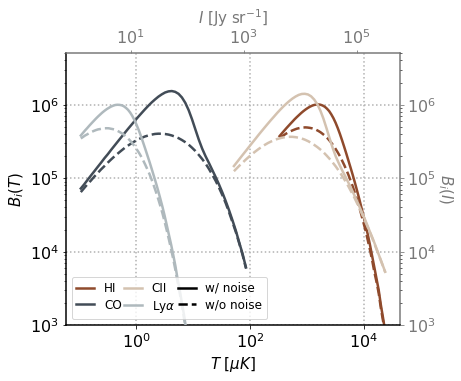

In [59]:
from matplotlib.lines import Line2D

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(6,5))
ax00=fig.add_subplot(111)
ax01=fig.add_subplot(111, frame_on=False)

ax00.loglog(TiCO, BiCO_noise, color=dark_blue)
ax00.loglog(TiCO, BiCO_nonoise, '--', color=dark_blue)
ax00.loglog(TiHI, BiHI_noise, color=dark_red)
ax00.loglog(TiHI, BiHI_nonoise, '--', color=dark_red)
ax00.set_xlabel(r"$T$ [$\mu K$]", fontsize = 15)
ax00.set_ylabel("$B_{i}(T)$", fontsize=15)
ax00.set_ylim(1e3,5e6)

ax01.xaxis.tick_top()
ax01.yaxis.tick_right()
ax01.loglog(TiLya, BiLya_noise, color=light_blue)
ax01.loglog(TiLya, BiLya_nonoise, '--', color=light_blue)
ax01.loglog(TiCII, BiCII_noise, color=light_red)
ax01.loglog(TiCII, BiCII_nonoise, '--', color=light_red)
ax01.set_xlabel("$I$ [Jy sr$^{-1}$]", fontsize = 15)
ax01.set_ylabel("$B_{i}(I)$",color=grey, fontsize=15, rotation=270, labelpad=18)
ax01.set_ylim(1e3,5e6)

ax01.yaxis.label.set_color(grey)
ax01.yaxis.set_label_position('right') 
ax01.tick_params(axis='y', colors=grey)
#ax01.axes.get_xaxis().set_ticks([])

ax01.xaxis.label.set_color(grey)
ax01.xaxis.set_label_position('top') 
ax01.tick_params(axis='x', colors=grey)

ax01.spines['top'].set_edgecolor(grey)
ax00.spines['right'].set_edgecolor(grey)
ax00.spines['top'].set_edgecolor(grey)

ax00.grid(linestyle='dotted', linewidth=1.5)

custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], color=dark_blue, lw=2.5),
                Line2D([0], [0], color=light_red, lw=2.5),
                Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], color= 'black', lw=2.5),
                Line2D([0], [0], linestyle='--',color= 'black', lw=2.5)]
ax01.legend(custom_lines, ['HI', 'CO', 'CII',r'Ly$\alpha$', 'w/ noise', 'w/o noise'], 
            ncol=3, fontsize=12, labelspacing=0.3, columnspacing=0.2, handlelength=1.5, loc='lower left')
#plt.savefig('../../VID_fid.pdf', bbox_inches='tight', dpi=300)

In [16]:
LC_CO.update(kmax=3*u.Mpc**-1)
LC_CII.update(kmax=3*u.Mpc**-1)
LC_Lya.update(kmax=3*u.Mpc**-1)
LC_HI.update(kmax=3*u.Mpc**-1)

In [35]:
#save files with h-ful units
np.save('../../PkCO_noise_T', [LC_CO.k_Pk_poles, LC_CO.Pk_0, LC_CO.Pk_2])
np.save('../../PkCII_noise_I', [LC_CII.k_Pk_poles, LC_CII.Pk_0, LC_CII.Pk_2])
np.save('../../PkLya_noise_I', [LC_Lya.k_Pk_poles, LC_Lya.Pk_0, LC_Lya.Pk_2])
np.save('../../PkHI_noise_T', [LC_HI.k_Pk_poles, LC_HI.Pk_0, LC_HI.Pk_2])

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


The target line requires z_max = 3.567 instead of the nominal 3.500


../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.2260928678521218
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))
../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.21690681990786664
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


The target line requires z_max = 3.567 instead of the nominal 3.500


../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CII line left out filtering = 0.22609351109309683
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))
../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078652
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


The target line requires z_max = 3.567 instead of the nominal 3.500


../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of Lyalpha line left out filtering = 0.22609306652174377
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))
../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.2169068199078663
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


The target line requires z_max = 3.567 instead of the nominal 3.500


../../preLIMinary/source/survey.py:428: UserWarning: Filling the corners requires a buffering z_max = 3.567, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of HI line left out filtering = 0.22609324449220436
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [29]:
kCO_nonoise, PkCO_0_nonoise, PkCO_2_nonoise = np.load('../../PkCO_noiseless_T.npy')
kCO_nonoise = kCO_nonoise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkCO_0_nonoise = PkCO_0_nonoise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)
PkCO_2_nonoise = PkCO_2_nonoise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)

kCII_nonoise, PkCII_0_nonoise, PkCII_2_nonoise = np.load('../../PkCII_noiseless_I.npy')
kCII_nonoise = kCII_nonoise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkCII_0_nonoise = PkCII_0_nonoise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)
PkCII_2_nonoise = PkCII_2_nonoise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)

kLya_nonoise, PkLya_0_nonoise, PkLya_2_nonoise = np.load('../../PkLya_noiseless_I.npy')
kLya_nonoise = kLya_nonoise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkLya_0_nonoise = PkLya_0_nonoise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)
PkLya_2_nonoise = PkLya_2_nonoise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)

kHI_nonoise, PkHI_0_nonoise, PkHI_2_nonoise = np.load('../../PkHI_noiseless_T.npy')
kHI_nonoise = kHI_nonoise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkHI_0_nonoise = PkHI_0_nonoise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)
PkHI_2_nonoise = PkHI_2_nonoise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)

In [30]:
kCO_noise, PkCO_0_noise, PkCO_2_noise = np.load('../../PkCO_noise_T.npy')
kCO_noise = kCO_noise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkCO_0_noise = PkCO_0_noise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)
PkCO_2_noise = PkCO_2_noise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)

kCII_noise, PkCII_0_noise, PkCII_2_noise = np.load('../../PkCII_noise_I.npy')
kCII_noise = kCII_noise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkCII_0_noise = PkCII_0_noise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)
PkCII_2_noise = PkCII_2_noise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)

kLya_noise, PkLya_0_noise, PkLya_2_noise = np.load('../../PkLya_noise_I.npy')
kLya_noise = kLya_noise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkLya_0_noise = PkLya_0_noise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)
PkLya_2_noise = PkLya_2_noise[:68]*((u.Jy/u.sr)**2*LC_CO.Mpch**3).to((u.Jy/u.sr)**2*u.Mpc**3)

kHI_noise, PkHI_0_noise, PkHI_2_noise = np.load('../../PkHI_noise_T.npy')
kHI_noise = kHI_noise[:68]*(1/LC_CO.Mpch).to(1/u.Mpc)
PkHI_0_noise = PkHI_0_noise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)
PkHI_2_noise = PkHI_2_noise[:68]*(u.uK**2*LC_CO.Mpch**3).to(u.uK**2*u.Mpc**3)

In [34]:
kCOxCO, P0_COxCO, P2_COxCO=np.load('Pk_COxCO.npy')
kCIIxCII, P0_CIIxCII, P2_CIIxCII=np.load('Pk_CIIxCII.npy')
kLyaxLya, P0_LyaxLya, P2_LyaxLya=np.load('Pk_LyaxLya.npy')
kHIxHI, P0_HIxHI, P2_HIxHI=np.load('Pk_HIxHI.npy')
kCOxCII, P0_COxCII, P2_COxCII=np.load('Pk_COxCII.npy')
kCOxLya, P0_COxLya, P2_COxLya=np.load('Pk_COxLya.npy')
kCOxHI, P0_COxHI, P2_COxHI=np.load('Pk_COxHI.npy')
kCIIxLya, P0_CIIxLya, P2_CIIxLya=np.load('Pk_CIIxLya.npy')
kCIIxHI, P0_CIIxHI, P2_CIIxHI=np.load('Pk_CIIxHI.npy')
kLyaxHI, P0_LyaxHI, P2_LyaxHI=np.load('Pk_LyaxHI.npy')

In [52]:
cmap_CO = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#32465c', '#afb9bd'])
colors=cmap_CO(np.linspace(0,1,3))

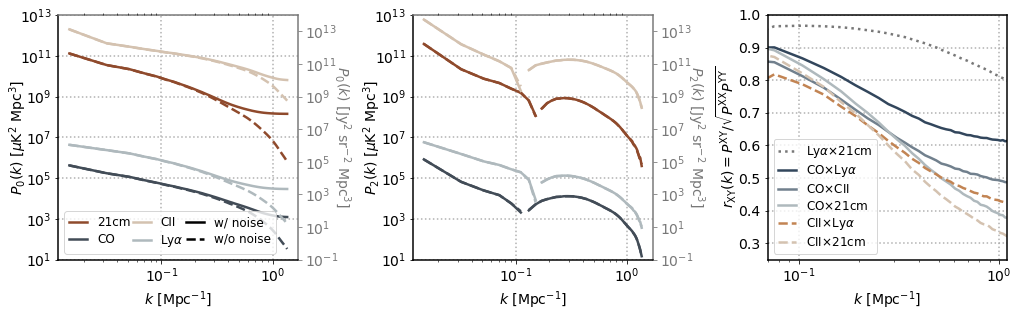

In [108]:
from matplotlib.lines import Line2D
plt.rcParams['font.size'] = 14

dark_blue='#424c57'
dark_red='#8f4a2c'
light_blue='#afb9bd'
light_red='#d4c2b0'
grey='#787878'

fig=plt.figure(figsize=(17,4.5))
gs = GridSpec(1, 3, figure=fig, wspace=0.48)

#fig=plt.figure(figsize=(15,5))
ax00=fig.add_subplot(gs[0,0])
ax01=fig.add_subplot(gs[0,0], frame_on=False)

ax00.loglog(kCO_noise, PkCO_0_noise, color=dark_blue)
ax00.loglog(kCO_nonoise, PkCO_0_nonoise, '--', color=dark_blue)
ax00.loglog(kHI_noise, PkHI_0_noise, color=dark_red)
ax00.loglog(kHI_nonoise, PkHI_0_nonoise, '--', color=dark_red)
ax00.set_xlabel("$k$ [Mpc$^{-1}$]")
ax00.set_ylabel("$P_0 (k)$ [$\mu$K$^2$ Mpc$^3$]", labelpad=-9)
ax00.set_ylim(1e1,1e13)

ax01.xaxis.tick_top()
ax01.yaxis.tick_right()
ax01.loglog(kLya_noise, PkLya_0_noise, color=light_blue)
ax01.loglog(kLya_nonoise, PkLya_0_nonoise, '--', color=light_blue)
ax01.loglog(kCII_noise, PkCII_0_noise, color=light_red)
ax01.loglog(kCII_nonoise, PkCII_0_nonoise, '--', color=light_red)
ax01.set_ylabel("$P_0 (k)$ [Jy$^2$ sr$^{-2}$ Mpc$^3$]",color=grey, rotation=270, labelpad=14)
ax01.set_ylim(1e-1, 1e14)

ax01.yaxis.label.set_color(grey)
ax01.yaxis.set_label_position('right') 
ax01.tick_params(axis='y', colors=grey)
ax01.axes.get_xaxis().set_ticks([])
ax01.tick_params(axis='x', colors=grey)
ax01.spines['top'].set_edgecolor(grey)
ax00.spines['right'].set_edgecolor(grey)
ax00.spines['top'].set_edgecolor(grey)

ax00.grid(linestyle='dotted', linewidth=1.5)

custom_lines = [Line2D([0], [0], color=dark_red, lw=2.5),
                Line2D([0], [0], color=dark_blue, lw=2.5),
                Line2D([0], [0], color=light_red, lw=2.5),
                Line2D([0], [0], color=light_blue, lw=2.5),
                Line2D([0], [0], color= 'black', lw=2.5),
                Line2D([0], [0], linestyle='--',color= 'black', lw=2.5)]
ax00.legend(custom_lines, ['21cm', 'CO', 'CII',r'Ly$\alpha$', 'w/ noise', 'w/o noise'], 
            ncol=3, fontsize=12, labelspacing=0.3, columnspacing=0.2, handlelength=1.5, loc='lower left')

ax10=fig.add_subplot(gs[0,1])
ax11=fig.add_subplot(gs[0,1], frame_on=False)

ax10.loglog(kCO_noise[PkCO_2_noise>=0], PkCO_2_noise[PkCO_2_noise>=0], color=dark_blue)
ax10.loglog(kCO_noise[PkCO_2_noise<0], abs(PkCO_2_noise[PkCO_2_noise<0]), color=dark_blue)
ax10.loglog(kCO_noise[PkCO_2_nonoise>=0], PkCO_2_nonoise[PkCO_2_nonoise>=0], '--', color=dark_blue)
ax10.loglog(kCO_noise[PkCO_2_nonoise<0], abs(PkCO_2_nonoise[PkCO_2_nonoise<0]), '--', color=dark_blue)
ax10.loglog(kHI_noise[PkHI_2_noise>=0], PkHI_2_noise[PkHI_2_noise>=0], color=dark_red)
ax10.loglog(kHI_noise[PkHI_2_noise<0], abs(PkHI_2_noise[PkHI_2_noise<0]), color=dark_red)
ax10.loglog(kHI_noise[PkHI_2_nonoise>=0], PkHI_2_nonoise[PkHI_2_nonoise>=0], '--', color=dark_red)
ax10.loglog(kHI_noise[PkHI_2_nonoise<0], abs(PkHI_2_nonoise[PkHI_2_nonoise<0]), '--', color=dark_red)

ax10.set_xlabel("$k$ [Mpc$^{-1}]$")
ax10.set_ylabel("$P_2 (k)$ [$\mu$K$^2$ Mpc$^3$]", labelpad=-9)
ax10.set_ylim(1e1,1e13)

ax11.xaxis.tick_top()
ax11.yaxis.tick_right()

ax11.loglog(kLya_noise[PkLya_2_noise>=0], PkLya_2_noise[PkLya_2_noise>=0], color=light_blue)
ax11.loglog(kLya_noise[PkLya_2_noise<0], abs(PkLya_2_noise[PkLya_2_noise<0]), color=light_blue)
ax11.loglog(kLya_noise[PkLya_2_nonoise>=0], PkLya_2_nonoise[PkLya_2_nonoise>=0], '--', color=light_blue)
ax11.loglog(kLya_noise[PkLya_2_nonoise<0], abs(PkLya_2_nonoise[PkLya_2_nonoise<0]), '--', color=light_blue)
ax11.loglog(kCII_noise[PkCII_2_noise>=0], PkCII_2_noise[PkCII_2_noise>=0], color=light_red)
ax11.loglog(kCII_noise[PkCII_2_noise<0], abs(PkCII_2_noise[PkCII_2_noise<0]), color=light_red)
ax11.loglog(kCII_noise[PkCII_2_nonoise>=0], PkCII_2_nonoise[PkCII_2_nonoise>=0], '--', color=light_red)
ax11.loglog(kCII_noise[PkCII_2_nonoise<0], abs(PkCII_2_nonoise[PkCII_2_nonoise<0]), '--', color=light_red)

ax11.set_ylabel("$P_2 (k)$ [Jy$^2$ sr$^{-2}$ Mpc$^3$]",color=grey, rotation=270, labelpad=14)
ax11.set_ylim(1e-1, 1e14)

ax11.yaxis.label.set_color(grey)
ax11.yaxis.set_label_position('right') 
ax11.tick_params(axis='y', colors=grey)
ax11.axes.get_xaxis().set_ticks([])
ax11.tick_params(axis='x', colors=grey)
ax11.spines['top'].set_edgecolor(grey)
ax10.spines['right'].set_edgecolor(grey)
ax10.spines['top'].set_edgecolor(grey)
ax10.grid(linestyle='dotted', linewidth=1.5)

ax20=fig.add_subplot(gs[0,2])
plt.plot(kLyaxHI, P0_LyaxHI/np.sqrt(P0_HIxHI*P0_LyaxLya), ':', label=r'Ly$\alpha$$\times$21cm', color=grey)
ax20.plot(kCOxLya, P0_COxLya/np.sqrt(P0_COxCO*P0_LyaxLya), label=r'CO$\times$Ly$\alpha$', color=colors[0])
ax20.plot(kCOxCII, P0_COxCII/np.sqrt(P0_COxCO*P0_CIIxCII), label=r'CO$\times$CII', color=colors[1])
ax20.plot(kCOxHI, P0_COxHI/np.sqrt(P0_COxCO*P0_HIxHI), label=r'CO$\times$21cm', color=colors[2])
ax20.plot(kCIIxLya, P0_CIIxLya/np.sqrt(P0_CIIxCII*P0_LyaxLya), '--', label=r'CII$\times$Ly$\alpha$', color="#c28453")
ax20.plot(kCIIxHI, P0_CIIxHI/np.sqrt(P0_CIIxCII*P0_HIxHI), '--', label=r'CII$\times$21cm', color=light_red)
ax20.legend(fontsize=12, labelspacing=0.3, columnspacing=0.2, handlelength=1.5)
ax20.set_xlim(0.07, 1.1)
ax20.set_ylim(0.25, 1)
ax20.set_xlabel("$k$ [Mpc$^{-1}]$")
ax20.set_ylabel(r'$r_{\rm XY}(k) = P^{\rm XY}/\sqrt{P^{\rm XX}P^{\rm YY}}$', labelpad=-1)
ax20.set_xscale('log')
ax20.grid(linestyle='dotted', linewidth=1.5)


#plt.tight_layout()
plt.savefig('../../Pk_fid2.pdf', bbox_inches='tight', dpi=300)
plt.savefig('../../Pk_fid2.png', bbox_inches='tight', dpi=300)

### anisotropy near $k_{max}$ investigation

In [7]:
kCO_nonoise=LC_CO.k_Pk_poles.to(1/u.Mpc)
PkCO_0_nonoise=LC_CO.Pk_0.to(u.uK**2*u.Mpc**3)
PkCO_2_nonoise=LC_CO.Pk_2.to(u.uK**2*u.Mpc**3)

Pk2d_nonoise=LC_CO.Pk_2d.power

In [33]:
Lbox=LC_CO.Lbox.to(u.Mpc)
Nmesh=LC_CO.obs_3d_map.shape
kmax=np.pi*np.sqrt((Nmesh[0]/Lbox[0])**2 + (Nmesh[1]/Lbox[1])**2 + (Nmesh[2]/Lbox[2])**2)
kmax_par=np.pi*np.sqrt((Nmesh[0]/Lbox[0])**2)
kmax_perp=np.pi*np.sqrt((Nmesh[1]/Lbox[1])**2 + (Nmesh[2]/Lbox[2])**2)

print(kmax, kmax_par, kmax_perp)

3.4094566724945268 1 / Mpc 2.2825238357132123 1 / Mpc 2.532682321377574 1 / Mpc


In [29]:
#LC_CO.update(Tsys=6.59*u.K)
LC_CO.update(kmax=2*u.Mpc**-1)

kCO_noise=LC_CO.k_Pk_poles.to(1/u.Mpc)
PkCO_0_noise=LC_CO.Pk_0.to(u.uK**2*u.Mpc**3)
PkCO_2_noise=LC_CO.Pk_2.to(u.uK**2*u.Mpc**3)

Pk2d_noise=LC_CO.Pk_2d.power

In [42]:
index=98
print(kCO_noise[index])
print(Pk2d_noise['mu'][index,:])

1.9699977058562446 1 / Mpc
[-0.95000101 -0.84994688 -0.74999501 -0.65009183 -0.55002737 -0.45074694
 -0.35253906 -0.25167337 -0.15092978 -0.05094846  0.0491486   0.15092978
  0.25167337  0.35253906  0.45074694  0.55002737  0.65009183  0.74999501
  0.84994688  0.95000101]


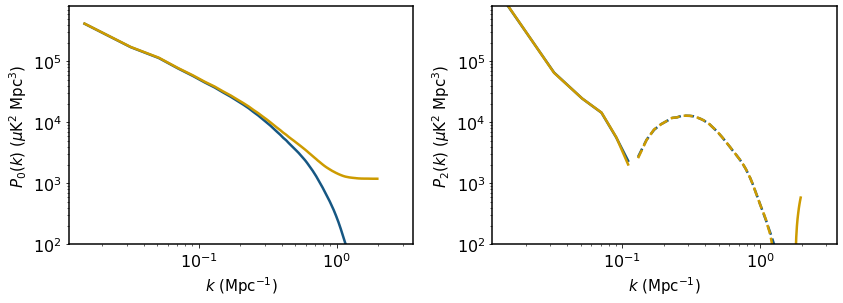

In [50]:
plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.loglog(kCO_nonoise, PkCO_0_nonoise)
plt.loglog(kCO_noise, PkCO_0_noise)
plt.xlabel("$k$ (Mpc$^{-1})$", fontsize = 15)
plt.ylabel("$P_0 (k)$ ($\mu$K$^2$ Mpc$^3$)", fontsize=15)
plt.ylim(1e2, 8e5)

plt.subplot(1,2,2)
plt.loglog(kCO_nonoise[PkCO_2_nonoise>=0], PkCO_2_nonoise[PkCO_2_nonoise>=0])
plt.loglog(kCO_nonoise[PkCO_2_nonoise<0], abs(PkCO_2_nonoise[PkCO_2_nonoise<0]), 'C0--')
plt.loglog(kCO_noise[:70][PkCO_2_noise[:70]>=0], PkCO_2_noise[:70][PkCO_2_noise[:70]>=0], 'C1')
plt.loglog(kCO_noise[PkCO_2_noise<0], abs(PkCO_2_noise[PkCO_2_noise<0]), 'C1--')
plt.loglog(kCO_noise[70:][PkCO_2_noise[70:]>=0], PkCO_2_noise[70:][PkCO_2_noise[70:]>=0], 'C1')

plt.ylim(1e2, 8e5)
plt.xlabel("$k$ (Mpc$^{-1})$", fontsize = 15)
plt.ylabel("$P_2 (k)$ ($\mu$K$^2$ Mpc$^3$)", fontsize=15)

plt.tight_layout()

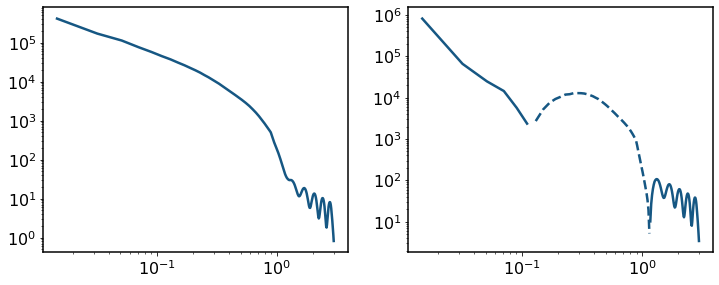

In [35]:
plt.figure(figsize=(12,4.5))
plt.subplot(1,2,1)
plt.loglog(kCO_nonoise, PkCO_0_nonoise)

plt.subplot(1,2,2)
plt.loglog(kCO_nonoise[:50][PkCO_2_nonoise[:50]>=0], PkCO_2_nonoise[:50][PkCO_2_nonoise[:50]>=0])
plt.loglog(kCO_nonoise[PkCO_2_nonoise<0], abs(PkCO_2_nonoise[PkCO_2_nonoise<0]), 'C0--')
plt.loglog(kCO_nonoise[50:][PkCO_2_nonoise[50:]>=0], PkCO_2_nonoise[50:][PkCO_2_nonoise[50:]>=0], 'C0')


In [51]:
from nbodykit.algorithms import FFTPower
import pmesh

pm = pmesh.pm.ParticleMesh(LC_CO.obs_3d_map.shape, BoxSize=LC_CO.Lbox, dtype='float32', resampler=LC_CO.resampler)
field = pm.create(type='real')
field[:] = 0.
field+=LC_CO.noise_3d_map

Pk_noise=FFTPower(field, '2d', Nmu=LC_CO.Nmu, poles=[0,2], los=[1,0,0],
                                dk=LC_CO.dk.value,kmin=LC_CO.kmin.to(LC_CO.Mpch**-1).value,
                                kmax=LC_CO.kmax.value,BoxSize=LC_CO.Lbox.value)

In [52]:
k=(Pk_noise.poles['k']*LC_CO.Mpch**-1).to(u.Mpc**-1)
Pk=(Pk_noise.poles['power_2'].real*LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit**2

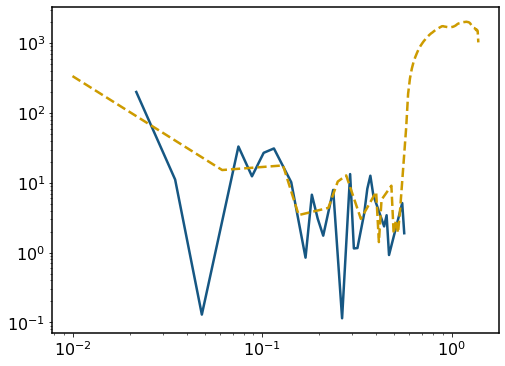

In [55]:
plt.loglog(k[Pk>=0], Pk[Pk>=0])
plt.loglog(k[Pk<0], abs(Pk[Pk<0]), '--')

In [34]:
LC_CO.update(RAObs_min=-2*u.deg,RAObs_max=2*u.deg, DECObs_min=-2*u.deg,DECObs_max=2*u.deg, 
             Tsys=np.sqrt((400/16))*6.59*u.K, kmax=3*u.Mpc**-1)

In [35]:
kCO_test = LC_CO.k_Pk_poles*(LC_CO.Mpch**-1).to(u.Mpc**-1)
PkCO_2_test = LC_CO.Pk_2*(LC_CO.Mpch**3).to(u.Mpc**3)*LC_CO.unit

../../preLIMinary/source/survey.py:320: UserWarning: % of survey volume lost due to inner cube = 0.14371495576960258
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))


The CO_J10 line requires z_max = 3.502 instead of the nominal 3.500


../../preLIMinary/source/survey.py:433: UserWarning: Filling the corners requires a buffering z_max = 3.502, but input z_max = 3.530. Corners will not be completely filled
  warn('Filling the corners requires a buffering z_max = {:.3f}, but input z_max = {:.3f}. Corners will not be completely filled'.format(zbuffer,self.zmax))
../../preLIMinary/source/survey.py:670: UserWarning: % of emitters of CO_J10 line left out filtering = 0.14319547881858818
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


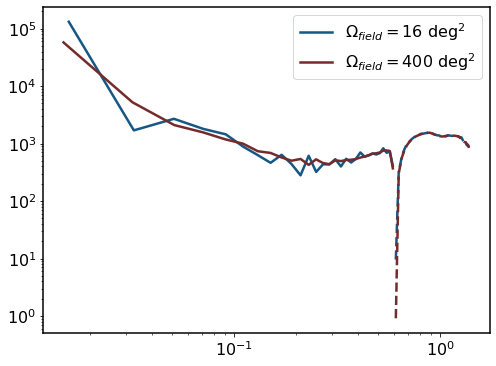

In [36]:
plt.loglog(kCO_test[PkCO_2_test>=0], PkCO_2_test[PkCO_2_test>=0], 'C0', label=r'$\Omega_{field} = 16$ deg$^2$')
plt.loglog(kCO_test[PkCO_2_test<0], abs(PkCO_2_test[PkCO_2_test<0]),  'C0--')
plt.loglog(kCO_noise[PkCO_2_noise>=0], PkCO_2_noise[PkCO_2_noise>=0], color=dark_red, label=r'$\Omega_{field} = 400$ deg$^2$')
plt.loglog(kCO_noise[PkCO_2_noise<0], abs(PkCO_2_noise[PkCO_2_noise<0]), '--', color=dark_red)
plt.legend()